In [212]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from scipy.fftpack import fft, rfft

In [276]:
#returns logistic map values for initial condition a and num steps n
def logistic_map(n, a, noise=0.0):
    memo = [0]*(n)
    memo[0] = a
    for i in range(1, n):
        x_old = memo[i-1]
        random_noise = np.random.normal(0.0, noise)
        #print(random_noise)
        x_next = 4*x_old*(1-x_old)
        if (x_next + random_noise > 1.0) | ((x_next + random_noise < 0.0)) :
            random_noise = 0.0
        memo[i] = x_next + random_noise
    return np.array(memo).reshape(-1,1)

#returns fiboncacci sequence of size n
def fibonacci(n):
    if n > 90:
        print("int overflow expected for n={}".format(n))
        return
    memo = [0] * n
    memo[1] = 1
    for i in range(2,n):
        memo[i] = memo[i-1]+memo[i-2]
    return np.array(memo).reshape(-1,1)

#returns fiboncacci sequence of size n mod prime number m
def fibonacci_mod_prime(n, m):
    memo = [0] * n
    memo[1] = 1
    for i in range(2,n):
        memo[i] = memo[i-1]+memo[i-2]
        if memo[i] >= m:
            memo[i] %= m
    return np.array(memo).reshape(-1,1)

#returns sine values for initial condition a (phase) and num steps n and frequency f
def sine(n, a, f):
    t = np.arange(0, n)
    #T = 1.0 / n
    #x = np.linspace(0.0, n*T, n)
    #y = np.sin(2.0*np.pi* (x + a))
    return np.sin((t/f + a) * 2*np.pi).reshape(-1,1)
    #return y
    
def pi_digits():
    memo = []
    filenm = "pi.txt"
    f = open(filenm, "r")
    for line in f.readlines():
        for ch in line:
            if ch != '\n':
                memo.append(int(ch))
    return np.array(memo).reshape(-1,1)

def plot_fig(x,y,title, x_label, y_label, linewidth=1):
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.tight_layout()
    plt.plot(x,y, linewidth=linewidth)

In [3]:
title_a = r'$x_{n+1} = 4x_n(1-x_n)$'
title_c = r'$x_n = Fib(n)$ mod $113$'
title_d = r'$y = sin(\omega t)$'
title_e = r'$x_n = Digits_{\pi}(n)$'

In [349]:
t = np.arange(0, 10000)
a = logistic_map(10000,0.2) 
c = fibonacci_mod_prime(10000, 113)
d = sine(10000, 0, 25)
e = pi_digits()

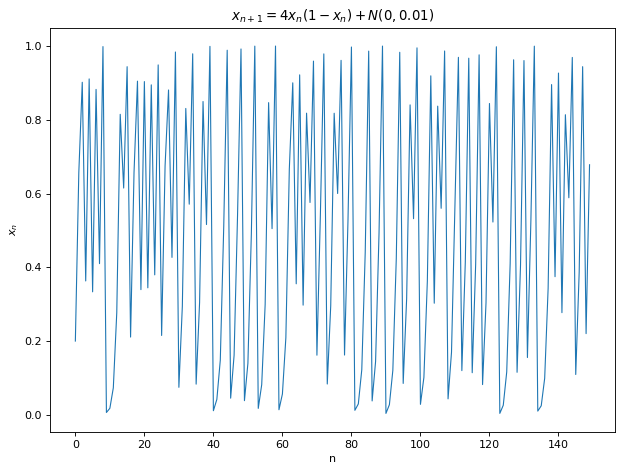

In [8]:
plot_fig(t[:150],a_noisy[:150],title_a_noisy,'n',r'$x_n$')

In [19]:
a_noisy = logistic_map(10000,0.2, 0.01)
title_a_noisy = r'$x_{n+1} = 4x_n(1-x_n) + N(0,0.01)$'

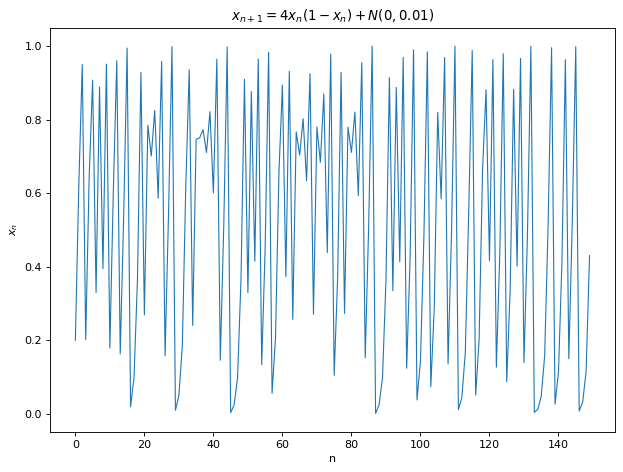

In [20]:
plot_fig(t[:150],a_noisy[:150],title_a_noisy,'n',r'$x_n$')

In [405]:
def load_model(name):
    from keras.models import model_from_json
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{}.h5".format(name)) 
    return loaded_model

def save_model(model, name = "model"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+".h5")
    print("Saved model to disk")
    
def create_regression_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)

def custom_loss(y_true, y_pred):
    difference = tf.abs(y_true - tf.round(y_pred))
    #difference = 1/tf.log(tf.square(y_true - y_pred))
    return tf.reduce_mean(difference, axis=-1)

def rms_loss(y_true, y_pred):
    difference = tf.sqrt(tf.square(y_true - y_pred))
    #difference = 1/tf.log(tf.square(y_true - y_pred))
    return tf.reduce_mean(difference, axis=-1)

#run lstm training on 1d model
def lstm_regressor(dataset, scaler, look_back, batch_sz, epoch,old=None):
    #train_size = int(len(dataset) * 0.67)
    train_size = int(len(dataset) * 0.025)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    trainX, trainY = create_regression_dataset(train, look_back)
    testX, testY = create_regression_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    loss = None
    if not old:
        """
        # create and fit the LSTM network
        model = Sequential()
        model.add(Bidirectional(LSTM(80,  return_sequences=True, input_shape=(look_back, 1))))
        model.add(Bidirectional(LSTM(12, return_sequences=False)))
        #model.add(Bidirectional(LSTM(4, return_sequences=False)))
        #model.add(Bidirectional(LSTM(4, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
        model.add(Dense(8, activation='relu'))
        #model.add(Dropout(0.05))
        model.add(Dense(4))

        """
        # create and fit the LSTM network
        model = Sequential()
        model.add(Bidirectional(LSTM(124,  return_sequences=True, input_shape=(look_back, 1))))
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(8, return_sequences=False)))
        model.add(Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)))
        model.add(Dense(32, kernel_regularizer=regularizers.l1_l2(l1=5e-4, l2=5e-3)))
        model.add(Dense(16))
        #model.add(Dropout(0.05))
        #model.add(Dense(4, kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        #model.add(Dropout(0.01))
        model.add(Dense(1))
        model.compile(loss=rms_loss, optimizer='adam')
        #es = EarlyStopping(monitor='loss', mode='auto', patience=5, min_delta=0.0001, verbose=1)
        hist = model.fit(trainX, trainY, epochs=epoch, batch_size=batch_sz, verbose=1)
        loss = hist.history["loss"]
    else:
        model = load_model(old)
        
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
        
    if scaler != None:
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
    
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict
    
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    # plot baseline and predictions
    if scaler != None:
        plt.plot(scaler.inverse_transform(dataset))
    else:
        plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    
    return model, trainPredict, testPredict, loss 

def test_running_model(model, data_, start, end, look_back = 4, observe_step = -1, title="", x0=0.2):
 
    data = data_[start:end+1].copy()
    t = end - (start + look_back )
    out = [0]*t
    j = 0
    init = data[:look_back].copy()
    for i in range(t):
        if observe_step > 0 and i % observe_step == 0:
            j = 0
            init = data[i:i+look_back].copy()        
        trainPredict = np.reshape(init, (init.shape[1],init.shape[0],1))
        testPredict = model.predict(trainPredict)
        out[i] = testPredict[0][0]
        init = np.concatenate((init[1:], testPredict))
        #j += 1
 
    #plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,6))

    x = np.arange(start,end)
    #x = np.arange(0,t)
    ax1.set_title('LSTM Reconstruction: {}'.format(title))
    #ax1.set_title(r'LSTM Reconstruction $t_{correction}$='+'{}: {}'.format(observe_step,title))
    ax1.set_ylabel(r'$x_n$')
    ax1.set_xlabel(r'$t$')
    #plt.tight_layout()
    ax1.plot(x[look_back: t], data[look_back:t].reshape(-1), label="original dataset")
    #ax1.plot(x[look_back:t], out[:-1*look_back], color = 'C2', label="test set, x0={}".format(x0))
    ax1.plot(x[look_back:t], out[:-1*look_back], color = 'C2', label="test set")
    #plt.clf()
    ax1.legend(loc='upper right')
    #return
    ax2.set_title('LSTM Reconstruction Error: {}'.format(title))
    ax2.set_ylabel(r'$|y_{pred} - y_{actual}| $')
    ax2.set_xlabel(r'$t$')
    out = np.array(out)
    diff = np.abs(data[look_back:t].reshape(-1)-out[:-1*look_back])
    print(diff.mean())
    ax2.plot(x[look_back:t],diff)

    return out


def test_epsilon_time(model, data_, start, end, look_back = 1, title=""):
    data = data_[start : end+1].copy()
    t = end - (start + look_back )
    out = [0]*t
    eps = 0.1
    for i in range(t):
        j = 0
        err = 0
        init = data[i:i+look_back].copy()
        while (err <= eps) and (i + j < t):      
            trainPredict = np.reshape(init, (init.shape[1],init.shape[0],1))
            testPredict = model.predict(trainPredict)
            err = abs(testPredict[0][0] - data[look_back + i + j][0])
            init = np.concatenate((init[1:], testPredict))
            j += 1
        out[i] = j
    
    x = np.arange(start,end-1)
    plt.clf()
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x, out)
    plt.ylim(bottom=0)
    plt.title(r'LSTM Max Prediction Intervals ($\varepsilon = 0.1$)' + ' : {}'.format(title))
    plt.ylabel(r'$t^{\varepsilon}$')
    plt.xlabel(r'$t$')
    plt.tight_layout()
    return np.array(out)

def test_running_model2(model, data_,training, back, start, end, look_back = 4, observe_step = -1, title=""):
    data = data_[start-back:end+1].copy()
    t = end - (start + look_back - back)
    out = [0]*t
    j = 0
    init = data[back:back+look_back].copy()
    for i in range(t):
        if observe_step > 0 and i % observe_step == 0:
            j = 0
            init = data[back+i:back+i+look_back].copy()
            if init.shape[0] == 51:
                break
        if init.shape[0] == 51:
            break
        trainPredict = np.reshape(init, (init.shape[1],init.shape[0],1))
        testPredict = model.predict(trainPredict)
        out[i] = testPredict[0][0]
        init = np.concatenate((init[1:], testPredict))
        
        #j += 1
 
    #plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax1 = plt.subplots(1, 1, figsize=(15,6))

    x = np.arange(start-back,end)
    #x = np.arange(0,t)
    plt.tight_layout()
    ax1.set_ylabel(r'$x_n$')
    ax1.set_xlabel(r'$t$')
    plt.tight_layout()
    ax1.plot(x[look_back: t], data[look_back:t].reshape(-1), label="original dataset")
    ax1.plot(x[look_back: back-1], training[start-back:end].reshape(-1), color = 'C1', label="train set")
    ax1.plot(x[look_back+back:back+t], out[:-look_back+50], color = 'C2', label="test set")
    ax1.set_title('LSTM Reconstruction: {}'.format(title))
    ax1.legend(loc='upper right')
    #plt.clf()
    return out


In [7]:
model5 = load_model('models/model5')
model4 = load_model('models/model4')

Instructions for updating:
Colocations handled automatically by placer.


In [142]:
a1 = logistic_map(50,0.3) 

0.010414892831793083


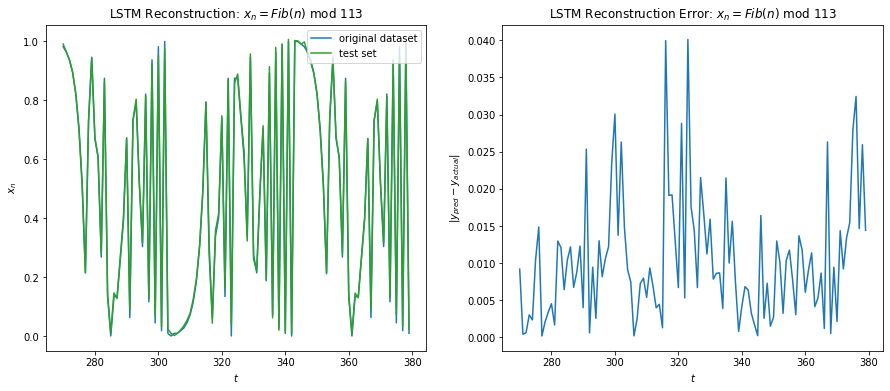

In [393]:
test = test_running_model(modelc, c_, 250, 250+150, 20, -1, title_c)

ValueError: x and y must have same first dimension, but have shapes (149,) and (49,)

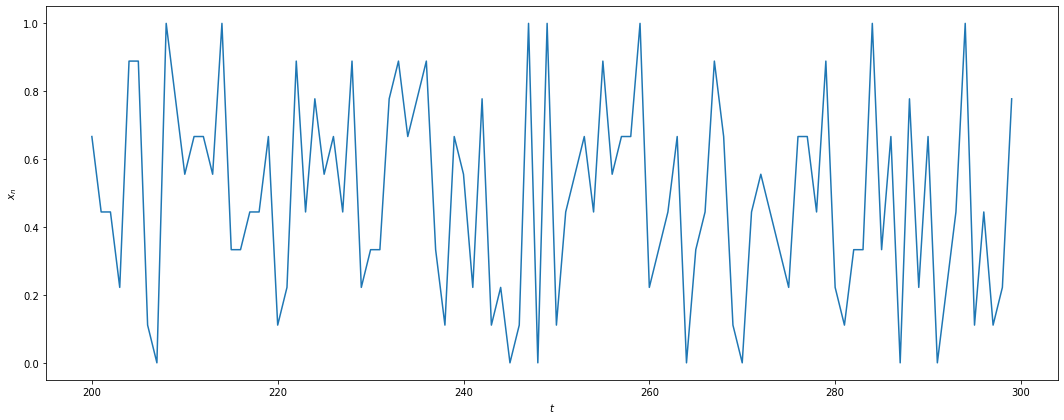

In [408]:
test = test_running_model2(model, e_, trainPredict, 250, 250, 250+50, 100, -1, title_e)

In [341]:
trainPredictc.shape

(20, 1)

<Figure size 432x288 with 0 Axes>

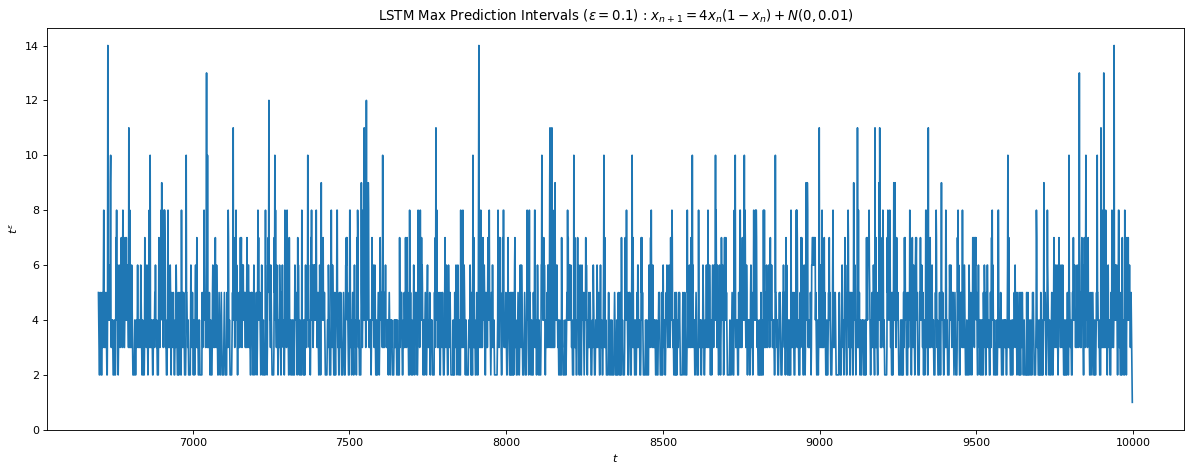

In [197]:
out = test_epsilon_time(model7,a, start=6699, end=10000, look_back=1, title=title_a_noisy )

In [148]:
out.mean()

NameError: name 'out' is not defined

In [ ]:
out = test_epsilon_time(model5,dataset, 6698, 10000, 1, title_a )

In [344]:
d_.shape

(1000, 1)

In [386]:
out.mean()

7.686761587397759

In [131]:
save_model(model,"model")

Saved model to disk


In [154]:
abs(trainPredict8-e_[6:1000-1]).mean()

0.03490480201195267

In [214]:
abs(trainPredict7-a[1:6699]).mean()

0.39313624809656983

In [212]:
abs(trainPredict5-a[1:6699]).mean()

0.0013856264867577123

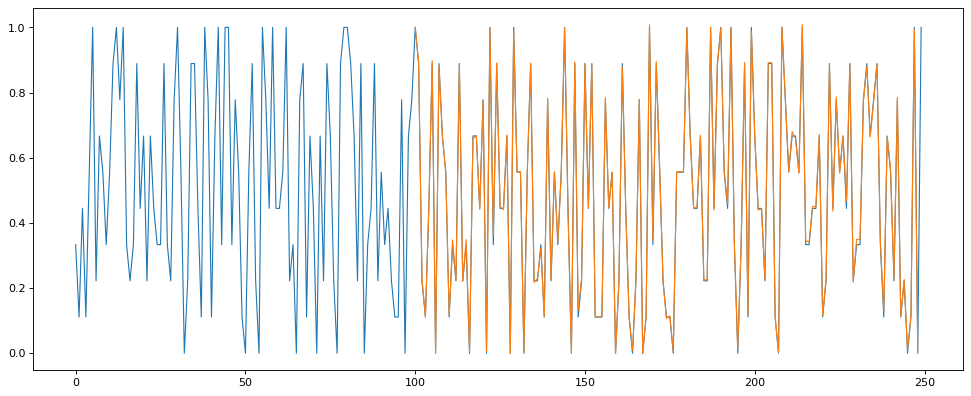

In [410]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dataset[:250],linewidth=1)
plt.plot(t[100:250-1], trainPredict[:250].reshape(-1), linewidth=1)

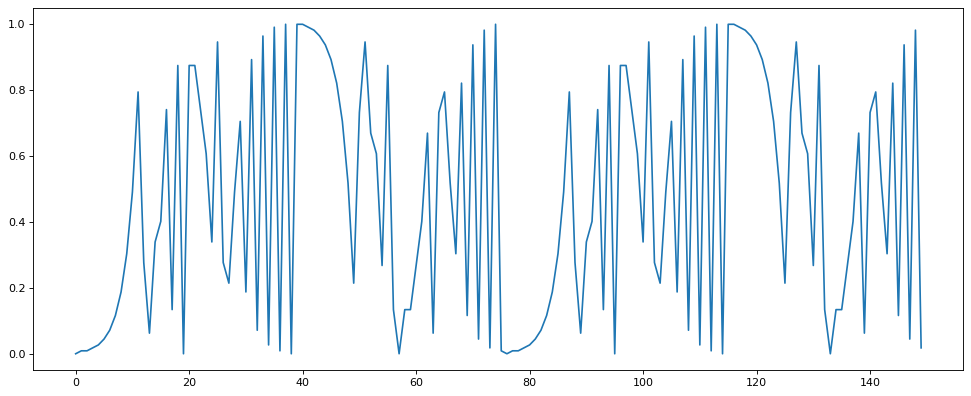

In [369]:
# normalize the dataset
#c_ = minmax_scale(c)
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dataset[:150])

Epoch 1/4000
149/149 [==============================] - 64s 433ms/step - loss: 1.0709
Epoch 2/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.9657
Epoch 3/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.9285
Epoch 4/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.8998
Epoch 5/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.8737
Epoch 6/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.8480
Epoch 7/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.8273
Epoch 8/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.8028
Epoch 9/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.7758
Epoch 10/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.7550
Epoch 11/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.7338
Epoch 12/4000
149/149 [==============================] - 3s 23ms/step - 

149/149 [==============================] - 4s 25ms/step - loss: 0.2873
Epoch 98/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.2883
Epoch 99/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2867
Epoch 100/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2861
Epoch 101/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2860
Epoch 102/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2870
Epoch 103/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2864
Epoch 104/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2851
Epoch 105/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2846
Epoch 106/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2852
Epoch 107/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.2846
Epoch 108/4000
149/149 [==============================] - 4s 25ms/step 

149/149 [==============================] - 4s 23ms/step - loss: 0.2644
Epoch 193/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2624
Epoch 194/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2621
Epoch 195/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2644
Epoch 196/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2631
Epoch 197/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2638
Epoch 198/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2690
Epoch 199/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2645
Epoch 200/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2671
Epoch 201/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2691
Epoch 202/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2633
Epoch 203/4000
149/149 [==============================] - 4s 24ms/ste

149/149 [==============================] - 4s 24ms/step - loss: 0.2602
Epoch 288/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2636
Epoch 289/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2603
Epoch 290/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2598
Epoch 291/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2618
Epoch 292/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2677
Epoch 293/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2610
Epoch 294/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.2607
Epoch 295/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2615
Epoch 296/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2575
Epoch 297/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2598
Epoch 298/4000
149/149 [==============================] - 3s 23ms/ste

149/149 [==============================] - 3s 23ms/step - loss: 0.2381
Epoch 383/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2403
Epoch 384/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2496
Epoch 385/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2521
Epoch 386/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2500
Epoch 387/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2423
Epoch 388/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2440
Epoch 389/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2409
Epoch 390/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.2395
Epoch 391/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.2390
Epoch 392/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.2374
Epoch 393/4000
149/149 [==============================] - 3s 22ms/ste

149/149 [==============================] - 3s 22ms/step - loss: 0.1829
Epoch 478/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1834
Epoch 479/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1774
Epoch 480/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1837
Epoch 481/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1800
Epoch 482/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1762
Epoch 483/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1855
Epoch 484/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1867
Epoch 485/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1924
Epoch 486/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1882
Epoch 487/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1827
Epoch 488/4000
149/149 [==============================] - 3s 22ms/ste

149/149 [==============================] - 3s 23ms/step - loss: 0.1587
Epoch 573/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1595
Epoch 574/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1629
Epoch 575/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.1594
Epoch 576/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.1574
Epoch 577/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1544
Epoch 578/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1537
Epoch 579/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.1524
Epoch 580/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.1565
Epoch 581/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.1614
Epoch 582/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.1537
Epoch 583/4000
149/149 [==============================] - 3s 23ms/ste

149/149 [==============================] - 4s 26ms/step - loss: 0.1532
Epoch 668/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.1482
Epoch 669/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.1438
Epoch 670/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1405
Epoch 671/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1430
Epoch 672/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.1412
Epoch 673/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1372
Epoch 674/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1332
Epoch 675/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1250
Epoch 676/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1273
Epoch 677/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.1244
Epoch 678/4000
149/149 [==============================] - 4s 24ms/ste

149/149 [==============================] - 4s 24ms/step - loss: 0.0618
Epoch 763/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0576
Epoch 764/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0594
Epoch 765/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0670
Epoch 766/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0734
Epoch 767/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0663
Epoch 768/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0626
Epoch 769/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0549
Epoch 770/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0552
Epoch 771/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0514
Epoch 772/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0495
Epoch 773/4000
149/149 [==============================] - 4s 24ms/ste

149/149 [==============================] - 3s 22ms/step - loss: 0.0481
Epoch 858/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0368
Epoch 859/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0316
Epoch 860/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0306
Epoch 861/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0317
Epoch 862/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0346
Epoch 863/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0334
Epoch 864/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0354
Epoch 865/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0350
Epoch 866/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0353
Epoch 867/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0379
Epoch 868/4000
149/149 [==============================] - 3s 22ms/ste

149/149 [==============================] - 4s 24ms/step - loss: 0.0292
Epoch 953/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0278
Epoch 954/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0287
Epoch 955/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0268
Epoch 956/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0269
Epoch 957/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0281
Epoch 958/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0248
Epoch 959/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0356
Epoch 960/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0313
Epoch 961/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0298
Epoch 962/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0285
Epoch 963/4000
149/149 [==============================] - 3s 23ms/ste

149/149 [==============================] - 3s 23ms/step - loss: 0.0265
Epoch 1047/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0214
Epoch 1048/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0254
Epoch 1049/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0263
Epoch 1050/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0237
Epoch 1051/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0222
Epoch 1052/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0236
Epoch 1053/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0217
Epoch 1054/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0216
Epoch 1055/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0219
Epoch 1056/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0254
Epoch 1057/4000
149/149 [==============================] - 

149/149 [==============================] - 4s 25ms/step - loss: 0.0191
Epoch 1141/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.0211
Epoch 1142/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0261
Epoch 1143/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0253
Epoch 1144/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0218
Epoch 1145/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0222
Epoch 1146/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0234
Epoch 1147/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0235
Epoch 1148/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0231
Epoch 1149/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.0270
Epoch 1150/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0257
Epoch 1151/4000
149/149 [==============================] - 

149/149 [==============================] - 4s 25ms/step - loss: 0.0215
Epoch 1235/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0186
Epoch 1236/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0221
Epoch 1237/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0222
Epoch 1238/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0224
Epoch 1239/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0200
Epoch 1240/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0207
Epoch 1241/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0200
Epoch 1242/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0190
Epoch 1243/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 1244/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0211
Epoch 1245/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0205
Epoch 1329/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0196
Epoch 1330/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0227
Epoch 1331/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0230
Epoch 1332/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0221
Epoch 1333/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0184
Epoch 1334/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0202
Epoch 1335/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0175
Epoch 1336/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0165
Epoch 1337/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0159
Epoch 1338/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0165
Epoch 1339/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0185
Epoch 1423/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0185
Epoch 1424/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0176
Epoch 1425/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0196
Epoch 1426/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0219
Epoch 1427/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0226
Epoch 1428/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0254
Epoch 1429/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0252
Epoch 1430/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0210
Epoch 1431/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0195
Epoch 1432/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0229
Epoch 1433/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0177
Epoch 1517/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0175
Epoch 1518/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0207
Epoch 1519/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0233
Epoch 1520/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0225
Epoch 1521/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0221
Epoch 1522/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0195
Epoch 1523/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0164
Epoch 1524/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0183
Epoch 1525/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0198
Epoch 1526/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0206
Epoch 1527/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0190
Epoch 1611/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0202
Epoch 1612/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0172
Epoch 1613/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0193
Epoch 1614/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0195
Epoch 1615/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0229
Epoch 1616/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0202
Epoch 1617/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0186
Epoch 1618/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0183
Epoch 1619/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0157
Epoch 1620/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0167
Epoch 1621/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0240
Epoch 1705/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0192
Epoch 1706/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0185
Epoch 1707/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0201
Epoch 1708/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0201
Epoch 1709/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.0223
Epoch 1710/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0216
Epoch 1711/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0191
Epoch 1712/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.0163
Epoch 1713/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0163
Epoch 1714/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0163
Epoch 1715/4000
149/149 [==============================] - 

149/149 [==============================] - 4s 25ms/step - loss: 0.0168
Epoch 1799/4000
149/149 [==============================] - 4s 26ms/step - loss: 0.0164
Epoch 1800/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0157
Epoch 1801/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0150
Epoch 1802/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0170
Epoch 1803/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0181
Epoch 1804/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0153
Epoch 1805/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0178
Epoch 1806/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0182
Epoch 1807/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0150
Epoch 1808/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0195
Epoch 1809/4000
149/149 [==============================] - 

149/149 [==============================] - 4s 25ms/step - loss: 0.0176
Epoch 1893/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0156
Epoch 1894/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0175
Epoch 1895/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0159
Epoch 1896/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0147
Epoch 1897/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0158
Epoch 1898/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0182
Epoch 1899/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0198
Epoch 1900/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0196
Epoch 1901/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0187
Epoch 1902/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0220
Epoch 1903/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0188
Epoch 1987/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0167
Epoch 1988/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0157
Epoch 1989/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0144
Epoch 1990/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0150
Epoch 1991/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0165
Epoch 1992/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0152
Epoch 1993/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0147
Epoch 1994/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0179
Epoch 1995/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0146
Epoch 1996/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0174
Epoch 1997/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0163
Epoch 2081/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0199
Epoch 2082/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0182
Epoch 2083/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0168
Epoch 2084/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0188
Epoch 2085/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0166
Epoch 2086/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0164
Epoch 2087/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0181
Epoch 2088/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0163
Epoch 2089/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0189
Epoch 2090/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0187
Epoch 2091/4000
149/149 [==============================] - 

149/149 [==============================] - 4s 25ms/step - loss: 0.0202
Epoch 2175/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0205
Epoch 2176/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0239
Epoch 2177/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0267
Epoch 2178/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0307
Epoch 2179/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0252
Epoch 2180/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0202
Epoch 2181/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0188
Epoch 2182/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0177
Epoch 2183/4000
149/149 [==============================] - 4s 25ms/step - loss: 0.0171
Epoch 2184/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0168
Epoch 2185/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0163
Epoch 2269/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0149
Epoch 2270/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0168
Epoch 2271/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0178
Epoch 2272/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0172
Epoch 2273/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0177
Epoch 2274/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0201
Epoch 2275/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0178
Epoch 2276/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0216
Epoch 2277/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0195
Epoch 2278/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0186
Epoch 2279/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0177
Epoch 2363/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0161
Epoch 2364/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0158
Epoch 2365/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0154
Epoch 2366/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0150
Epoch 2367/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0136
Epoch 2368/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0145
Epoch 2369/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0143
Epoch 2370/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0149
Epoch 2371/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0159
Epoch 2372/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0127
Epoch 2373/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0161
Epoch 2457/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0191
Epoch 2458/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0199
Epoch 2459/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0183
Epoch 2460/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0163
Epoch 2461/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0152
Epoch 2462/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0159
Epoch 2463/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0151
Epoch 2464/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0131
Epoch 2465/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0126
Epoch 2466/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0126
Epoch 2467/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0175
Epoch 2551/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0175
Epoch 2552/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0181
Epoch 2553/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0160
Epoch 2554/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0131
Epoch 2555/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0125
Epoch 2556/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0136
Epoch 2557/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0136
Epoch 2558/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0141
Epoch 2559/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0138
Epoch 2560/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0133
Epoch 2561/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0123
Epoch 2645/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0126
Epoch 2646/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0141
Epoch 2647/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0117
Epoch 2648/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0116
Epoch 2649/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0169
Epoch 2650/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0151
Epoch 2651/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0147
Epoch 2652/4000
149/149 [==============================] - 4s 24ms/step - loss: 0.0146
Epoch 2653/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0138
Epoch 2654/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0120
Epoch 2655/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0141
Epoch 2739/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0128
Epoch 2740/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 2741/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0129
Epoch 2742/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0134
Epoch 2743/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0130
Epoch 2744/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0140
Epoch 2745/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0151
Epoch 2746/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0163
Epoch 2747/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0190
Epoch 2748/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0175
Epoch 2749/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0133
Epoch 2833/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0125
Epoch 2834/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0132
Epoch 2835/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0131
Epoch 2836/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0134
Epoch 2837/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0155
Epoch 2838/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0155
Epoch 2839/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0169
Epoch 2840/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0154
Epoch 2841/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0129
Epoch 2842/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0125
Epoch 2843/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 2927/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0127
Epoch 2928/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0131
Epoch 2929/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0135
Epoch 2930/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0128
Epoch 2931/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0120
Epoch 2932/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0116
Epoch 2933/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0109
Epoch 2934/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0127
Epoch 2935/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0128
Epoch 2936/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0121
Epoch 2937/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 3021/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3022/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0103
Epoch 3023/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0113
Epoch 3024/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0119
Epoch 3025/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0115
Epoch 3026/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0115
Epoch 3027/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0117
Epoch 3028/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0119
Epoch 3029/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0123
Epoch 3030/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0121
Epoch 3031/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0111
Epoch 3115/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0114
Epoch 3116/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0119
Epoch 3117/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 3118/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0110
Epoch 3119/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0108
Epoch 3120/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0117
Epoch 3121/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0126
Epoch 3122/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3123/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0098
Epoch 3124/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0104
Epoch 3125/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0100
Epoch 3209/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0125
Epoch 3210/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 3211/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0114
Epoch 3212/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0109
Epoch 3213/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0109
Epoch 3214/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0114
Epoch 3215/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0099
Epoch 3216/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0116
Epoch 3217/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0136
Epoch 3218/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0112
Epoch 3219/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0134
Epoch 3303/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0133
Epoch 3304/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0122
Epoch 3305/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0142
Epoch 3306/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0147
Epoch 3307/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0188
Epoch 3308/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0188
Epoch 3309/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0159
Epoch 3310/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0144
Epoch 3311/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0126
Epoch 3312/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0120
Epoch 3313/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0103
Epoch 3397/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3398/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 3399/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0103
Epoch 3400/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0103
Epoch 3401/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0112
Epoch 3402/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0133
Epoch 3403/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0144
Epoch 3404/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0145
Epoch 3405/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0130
Epoch 3406/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0116
Epoch 3407/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0111
Epoch 3491/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 3492/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0127
Epoch 3493/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0124
Epoch 3494/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0119
Epoch 3495/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0110
Epoch 3496/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0092
Epoch 3497/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3498/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0120
Epoch 3499/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0114
Epoch 3500/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0102
Epoch 3501/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0119
Epoch 3585/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0129
Epoch 3586/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0116
Epoch 3587/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0111
Epoch 3588/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0097
Epoch 3589/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0083
Epoch 3590/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0099
Epoch 3591/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0093
Epoch 3592/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0096
Epoch 3593/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0107
Epoch 3594/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0123
Epoch 3595/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 3679/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0104
Epoch 3680/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 3681/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0107
Epoch 3682/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0098
Epoch 3683/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0111
Epoch 3684/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0090
Epoch 3685/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0111
Epoch 3686/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0093
Epoch 3687/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0100
Epoch 3688/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0187
Epoch 3689/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0126
Epoch 3773/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0134
Epoch 3774/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0127
Epoch 3775/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0110
Epoch 3776/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0100
Epoch 3777/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0088
Epoch 3778/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3779/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0093
Epoch 3780/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0098
Epoch 3781/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0099
Epoch 3782/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0104
Epoch 3783/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 22ms/step - loss: 0.0107
Epoch 3867/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0117
Epoch 3868/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0114
Epoch 3869/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0129
Epoch 3870/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0121
Epoch 3871/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0114
Epoch 3872/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0116
Epoch 3873/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0109
Epoch 3874/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 3875/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0106
Epoch 3876/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0112
Epoch 3877/4000
149/149 [==============================] - 

149/149 [==============================] - 3s 23ms/step - loss: 0.0081
Epoch 3961/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0084
Epoch 3962/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0097
Epoch 3963/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0085
Epoch 3964/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0088
Epoch 3965/4000
149/149 [==============================] - 3s 23ms/step - loss: 0.0090
Epoch 3966/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0092
Epoch 3967/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0091
Epoch 3968/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0093
Epoch 3969/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0088
Epoch 3970/4000
149/149 [==============================] - 3s 22ms/step - loss: 0.0090
Epoch 3971/4000
149/149 [==============================] - 

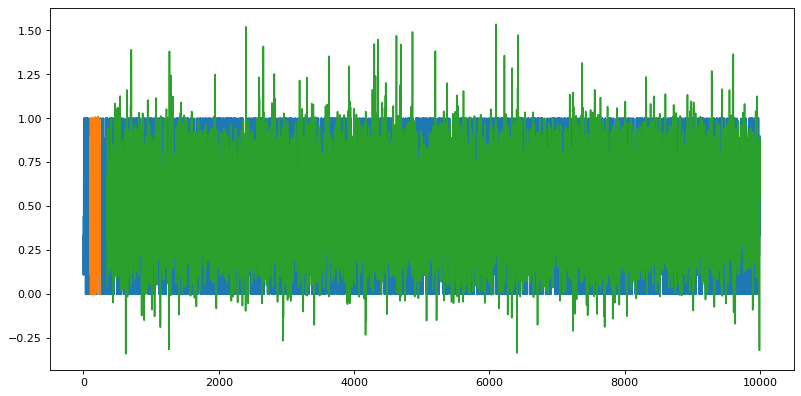

In [397]:
# normalize the dataset
e_ = minmax_scale(e)
dataset = e_
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
scaler = None
model, trainPredict, testPredict, losses =lstm_regressor(dataset.copy(), scaler, look_back=100, batch_sz=25, epoch=4000 )

In [348]:
trainPredictc

array([[0.9510107 ],
       [1.0023136 ],
       [1.0189939 ],
       [1.0062041 ],
       [0.96801805],
       [0.90682966],
       [0.8238828 ],
       [0.7204057 ],
       [0.59917295],
       [0.46622452],
       [0.33191162],
       [0.2099295 ],
       [0.11365487],
       [0.05118648],
       [0.02258933],
       [0.02209017],
       [0.04308847],
       [0.08172071],
       [0.13786036],
       [0.21452372]], dtype=float32)

In [227]:
# normalize the dataset
dataset = a
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
scaler = None
model5, trainPredict5, testPredict5, losses5 = lstm_regressor(dataset.copy(), scaler, look_back=1, batch_sz=15, epoch=500, old='models/' )

FileNotFoundError: [Errno 2] No such file or directory: 'models/.json'

In [9]:
model, trainPredict, testPredict, losses = lstm_train(dataset, scaler, 2)

NameError: name 'lstm_train' is not defined

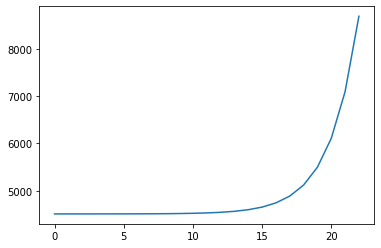

In [251]:
plt.plot(trainPredict)

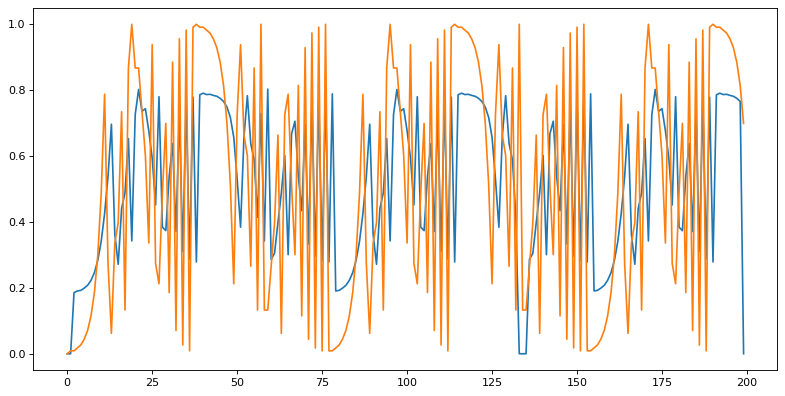

In [271]:
out_plot = np.zeros(len(dataset)).reshape(-1,1)
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
look_back = 2
out_plot[look_back:len(trainPredict)+look_back] = trainPredict
out_plot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict
plt.plot(out_plot)
plt.plot(c)

In [253]:
trainPredict

array([[4513.186 ],
       [4513.2563],
       [4513.358 ],
       [4513.531 ],
       [4513.805 ],
       [4514.2524],
       [4514.9736],
       [4516.142 ],
       [4518.0317],
       [4521.091 ],
       [4526.0386],
       [4534.045 ],
       [4547.    ],
       [4567.9614],
       [4601.878 ],
       [4656.756 ],
       [4745.55  ],
       [4889.2217],
       [5121.6855],
       [5497.82  ],
       [6106.4116],
       [7091.1196],
       [8684.374 ]], dtype=float32)

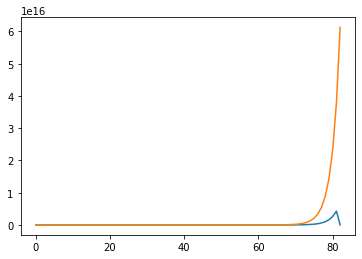

Epoch 1/1000
 - 6s - loss: 0.2216
Epoch 2/1000
 - 1s - loss: 0.1214
Epoch 3/1000
 - 1s - loss: 0.1074
Epoch 4/1000
 - 1s - loss: 0.1070
Epoch 5/1000
 - 1s - loss: 0.1060
Epoch 6/1000
 - 1s - loss: 0.1061
Epoch 7/1000
 - 1s - loss: 0.1042
Epoch 8/1000
 - 1s - loss: 0.1038
Epoch 9/1000
 - 1s - loss: 0.1030
Epoch 10/1000
 - 1s - loss: 0.1023
Epoch 11/1000
 - 1s - loss: 0.1021
Epoch 12/1000
 - 1s - loss: 0.1013
Epoch 13/1000
 - 1s - loss: 0.1006
Epoch 14/1000
 - 1s - loss: 0.1004
Epoch 15/1000
 - 1s - loss: 0.0997
Epoch 16/1000
 - 1s - loss: 0.0991
Epoch 17/1000
 - 1s - loss: 0.0988
Epoch 18/1000
 - 1s - loss: 0.0977
Epoch 19/1000
 - 1s - loss: 0.0968
Epoch 20/1000
 - 1s - loss: 0.0963
Epoch 21/1000
 - 1s - loss: 0.0957
Epoch 22/1000
 - 1s - loss: 0.0945
Epoch 23/1000
 - 1s - loss: 0.0944
Epoch 24/1000
 - 1s - loss: 0.0939
Epoch 25/1000
 - 1s - loss: 0.0928
Epoch 26/1000
 - 1s - loss: 0.0917
Epoch 27/1000
 - 1s - loss: 0.0918
Epoch 28/1000
 - 1s - loss: 0.0915
Epoch 29/1000
 - 1s - loss: 0

Epoch 232/1000
 - 1s - loss: 0.0867
Epoch 233/1000
 - 1s - loss: 0.0877
Epoch 234/1000
 - 1s - loss: 0.0874
Epoch 235/1000
 - 1s - loss: 0.0863
Epoch 236/1000
 - 1s - loss: 0.0877
Epoch 237/1000
 - 1s - loss: 0.0873
Epoch 238/1000
 - 1s - loss: 0.0873
Epoch 239/1000
 - 1s - loss: 0.0866
Epoch 240/1000
 - 1s - loss: 0.0882
Epoch 241/1000
 - 1s - loss: 0.0870
Epoch 242/1000
 - 1s - loss: 0.0869
Epoch 243/1000
 - 1s - loss: 0.0871
Epoch 244/1000
 - 1s - loss: 0.0871
Epoch 245/1000
 - 1s - loss: 0.0866
Epoch 246/1000
 - 1s - loss: 0.0864
Epoch 247/1000
 - 1s - loss: 0.0875
Epoch 248/1000
 - 1s - loss: 0.0869
Epoch 249/1000
 - 1s - loss: 0.0868
Epoch 250/1000
 - 1s - loss: 0.0866
Epoch 251/1000
 - 1s - loss: 0.0873
Epoch 252/1000
 - 1s - loss: 0.0872
Epoch 253/1000
 - 1s - loss: 0.0873
Epoch 254/1000
 - 1s - loss: 0.0866
Epoch 255/1000
 - 1s - loss: 0.0869
Epoch 256/1000
 - 1s - loss: 0.0874
Epoch 257/1000
 - 1s - loss: 0.0872
Epoch 258/1000
 - 1s - loss: 0.0866
Epoch 259/1000
 - 1s - loss:

Epoch 460/1000
 - 1s - loss: 0.0641
Epoch 461/1000
 - 1s - loss: 0.0639
Epoch 462/1000
 - 1s - loss: 0.0636
Epoch 463/1000
 - 1s - loss: 0.0639
Epoch 464/1000
 - 1s - loss: 0.0637
Epoch 465/1000
 - 1s - loss: 0.0633
Epoch 466/1000
 - 1s - loss: 0.0637
Epoch 467/1000
 - 1s - loss: 0.0631
Epoch 468/1000
 - 1s - loss: 0.0634
Epoch 469/1000
 - 1s - loss: 0.0631
Epoch 470/1000
 - 1s - loss: 0.0635
Epoch 471/1000
 - 1s - loss: 0.0623
Epoch 472/1000
 - 1s - loss: 0.0626
Epoch 473/1000
 - 1s - loss: 0.0626
Epoch 474/1000
 - 1s - loss: 0.0627
Epoch 475/1000
 - 1s - loss: 0.0628
Epoch 476/1000
 - 1s - loss: 0.0625
Epoch 477/1000
 - 1s - loss: 0.0618
Epoch 478/1000
 - 1s - loss: 0.0624
Epoch 479/1000
 - 1s - loss: 0.0625
Epoch 480/1000
 - 1s - loss: 0.0617
Epoch 481/1000
 - 1s - loss: 0.0618
Epoch 482/1000
 - 1s - loss: 0.0621
Epoch 483/1000
 - 1s - loss: 0.0613
Epoch 484/1000
 - 1s - loss: 0.0614
Epoch 485/1000
 - 1s - loss: 0.0622
Epoch 486/1000
 - 1s - loss: 0.0613
Epoch 487/1000
 - 1s - loss:

Epoch 688/1000
 - 1s - loss: 0.0469
Epoch 689/1000
 - 1s - loss: 0.0467
Epoch 690/1000
 - 1s - loss: 0.0471
Epoch 691/1000
 - 1s - loss: 0.0465
Epoch 692/1000
 - 1s - loss: 0.0471
Epoch 693/1000
 - 1s - loss: 0.0465
Epoch 694/1000
 - 1s - loss: 0.0470
Epoch 695/1000
 - 1s - loss: 0.0470
Epoch 696/1000
 - 1s - loss: 0.0475
Epoch 697/1000
 - 1s - loss: 0.0469
Epoch 698/1000
 - 1s - loss: 0.0460
Epoch 699/1000
 - 1s - loss: 0.0461
Epoch 700/1000
 - 1s - loss: 0.0465
Epoch 701/1000
 - 1s - loss: 0.0458
Epoch 702/1000
 - 1s - loss: 0.0471
Epoch 703/1000
 - 1s - loss: 0.0467
Epoch 704/1000
 - 1s - loss: 0.0468
Epoch 705/1000
 - 1s - loss: 0.0457
Epoch 706/1000
 - 1s - loss: 0.0457
Epoch 707/1000
 - 1s - loss: 0.0458
Epoch 708/1000
 - 1s - loss: 0.0462
Epoch 709/1000
 - 1s - loss: 0.0460
Epoch 710/1000
 - 1s - loss: 0.0465
Epoch 711/1000
 - 1s - loss: 0.0456
Epoch 712/1000
 - 1s - loss: 0.0459
Epoch 713/1000
 - 1s - loss: 0.0455
Epoch 714/1000
 - 1s - loss: 0.0458
Epoch 715/1000
 - 1s - loss:

Epoch 916/1000
 - 1s - loss: 0.0386
Epoch 917/1000
 - 1s - loss: 0.0385
Epoch 918/1000
 - 1s - loss: 0.0380
Epoch 919/1000
 - 1s - loss: 0.0378
Epoch 920/1000
 - 1s - loss: 0.0386
Epoch 921/1000
 - 1s - loss: 0.0381
Epoch 922/1000
 - 1s - loss: 0.0380
Epoch 923/1000
 - 1s - loss: 0.0376
Epoch 924/1000
 - 1s - loss: 0.0383
Epoch 925/1000
 - 1s - loss: 0.0376
Epoch 926/1000
 - 1s - loss: 0.0382
Epoch 927/1000
 - 1s - loss: 0.0378
Epoch 928/1000
 - 1s - loss: 0.0390
Epoch 929/1000
 - 1s - loss: 0.0399
Epoch 930/1000
 - 1s - loss: 0.0375
Epoch 931/1000
 - 1s - loss: 0.0381
Epoch 932/1000
 - 1s - loss: 0.0388
Epoch 933/1000
 - 1s - loss: 0.0377
Epoch 934/1000
 - 1s - loss: 0.0376
Epoch 935/1000
 - 1s - loss: 0.0375
Epoch 936/1000
 - 1s - loss: 0.0393
Epoch 937/1000
 - 1s - loss: 0.0379
Epoch 938/1000
 - 1s - loss: 0.0380
Epoch 939/1000
 - 1s - loss: 0.0381
Epoch 940/1000
 - 1s - loss: 0.0377
Epoch 941/1000
 - 1s - loss: 0.0381
Epoch 942/1000
 - 1s - loss: 0.0380
Epoch 943/1000
 - 1s - loss:

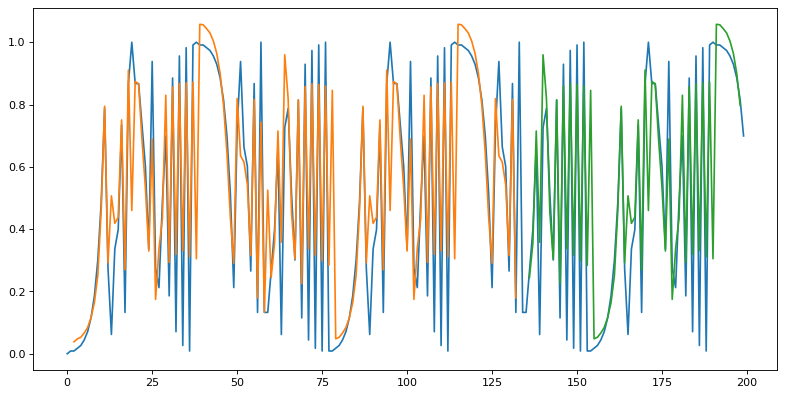

In [277]:
c = fibonacci_mod_prime(200, 113)/113.0
dataset = c
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
model, trainPredict, testPredict, losses = lstm_train(dataset, None, 2, 1000)

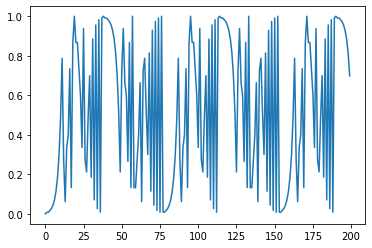

In [266]:
plt.plot(c)

In [161]:
b.reshape(-1, 1).shape

(90, 1)

In [182]:
(np.subtract(b[:-7].reshape(-1, 1),out_plot)).reshape(-1)

array([ 0.00000000e+00,  0.00000000e+00, -1.98091162e+10, -1.98091162e+10,
       -1.98091162e+10, -1.98091162e+10, -1.98091162e+10, -1.98091161e+10,
       -1.98091161e+10, -1.98091161e+10, -1.98091161e+10, -1.98091161e+10,
       -1.98091160e+10, -1.98091159e+10, -1.98091158e+10, -1.98091156e+10,
       -1.98091152e+10, -1.98091146e+10, -1.98091136e+10, -1.98091120e+10,
       -1.98091094e+10, -1.98091052e+10, -1.98090984e+10, -1.98090875e+10,
       -1.98090698e+10, -1.98090411e+10, -1.98089948e+10, -1.98089750e+10,
       -1.98088536e+10, -1.98086572e+10, -1.98083947e+10, -1.98080484e+10,
       -1.98073290e+10, -1.98061486e+10, -1.98043062e+10, -1.98013387e+10,
       -1.97965267e+10, -1.97887492e+10, -1.97761065e+10, -1.97557948e+10,
       -1.97227851e+10, -1.96694064e+10, -1.95831879e+10, -1.94434781e+10,
       -1.92174372e+10, -1.88517992e+10, -1.82601776e+10, -1.73028053e+10,
       -1.57538114e+10, -1.32475558e+10, -9.19219370e+09, -2.63057805e+09,
        7.98623178e+09,  

In [171]:
out_plot.reshape(-1)

array([0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.00000000e+00,
       3.00000000e+00, 5.00000000e+00, 8.00000000e+00, 1.30000000e+01,
       2.10000000e+01, 3.40000000e+01, 5.50000000e+01, 8.90000000e+01,
       1.44000000e+02, 2.33000000e+02, 3.77000000e+02, 6.10000000e+02,
       9.87000000e+02, 1.59700000e+03, 2.58400000e+03, 4.18100000e+03,
       6.76500000e+03, 1.09460000e+04, 1.77110000e+04, 2.86570000e+04,
       4.63680000e+04, 7.50250000e+04, 1.21393000e+05, 1.96418000e+05,
       3.17811000e+05, 5.14229000e+05, 8.32040000e+05, 1.34626900e+06,
       2.17830900e+06, 3.52457800e+06, 5.70288700e+06, 9.22746500e+06,
       1.49303520e+07, 2.41578170e+07, 3.90881690e+07, 6.32459860e+07,
       1.02334155e+08, 1.65580141e+08, 2.67914296e+08, 4.33494437e+08,
       7.01408733e+08, 1.13490317e+09, 1.83631190e+09, 2.97121507e+09,
       4.80752698e+09, 7.77874205e+09, 1.25862690e+10, 2.03650111e+10,
       3.29512801e+10, 5.33162912e+10, 8.62675713e+10, 1.39583862e+11,
      

In [5]:
c = logistic_map(10000, 0.2)

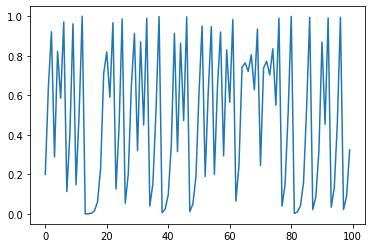

In [8]:
plt.plot(c[:100])

In [15]:
k = rfft(c)

In [11]:
#c = fibonacci_mod_prime(200, 113)/113.0
c = logistic_map(10000, 0.2)
dataset = c
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
model, trainPredict, testPredict, losses = lstm_classifier(dataset.copy(), k=2, look_back=2, epoch = 10, batch_size = 1 )

NameError: name 'lstm_classifier' is not defined

In [24]:
plt.clf()
look_back = 2
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = np.abs(trainPredict - c[look_back:len(trainPredict)+look_back])
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = np.abs(testPredict - c[len(trainPredict)+(look_back*2)+1:-1])


<Figure size 432x288 with 0 Axes>

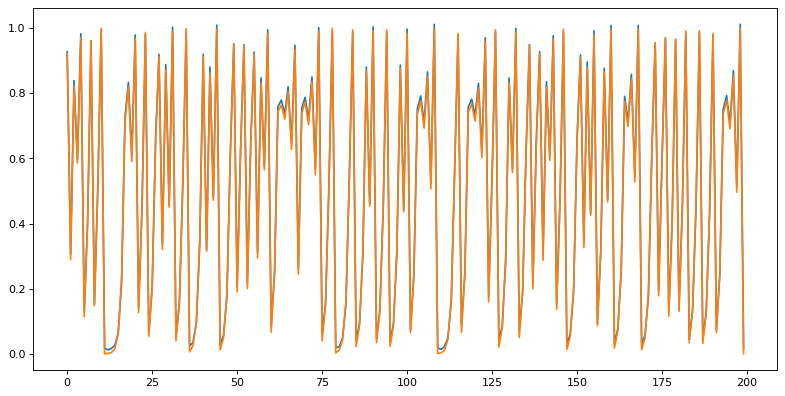

In [31]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(trainPredict[:200])
plt.plot(c[look_back:200+look_back])

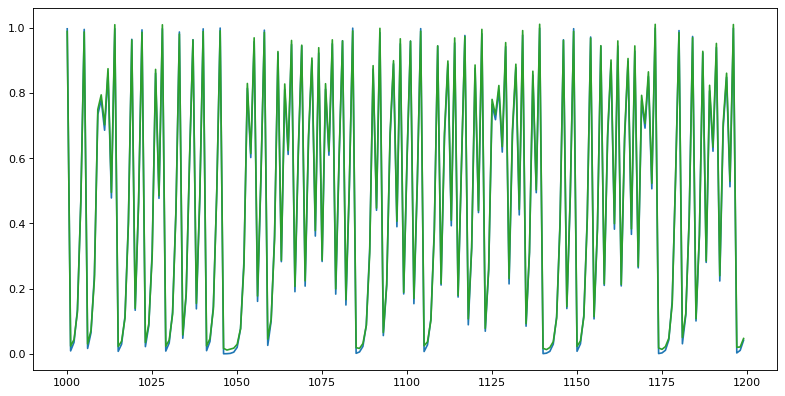

In [68]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
t = np.arange(1000, 1200)
plt.plot(t, c[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+200])
plt.plot(t, testPredict[:200], color="#2ca02c")

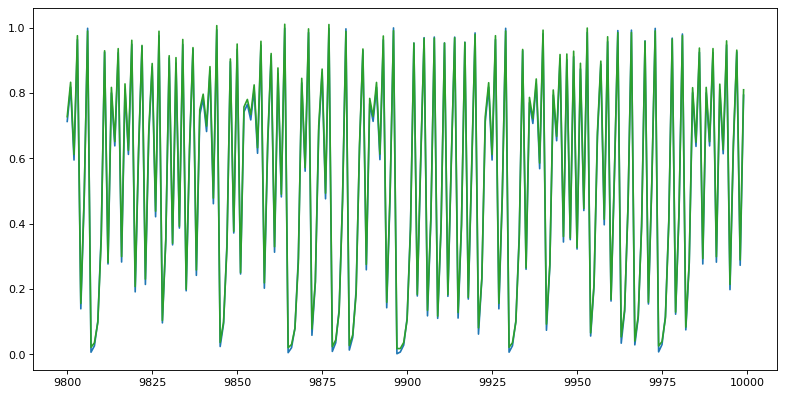

In [69]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
t = np.arange(10000-200, 10000)
plt.plot(t, c[-200-(look_back)+1:-1])
plt.plot(t, testPredict[-200:], color="#2ca02c")

In [203]:
def one_hot(X, K = 2):
    N = len(X)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, X[i]] = 1
    return ind

def create_classification_dataset(dataset, k=2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(one_hot(a,k))
        #dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), one_hot(np.array(dataY),k)

#run lstm training on 1d model
def lstm_classifier(dataset, k=2, look_back=2, epoch=10, batch_size=1):
    #train_size = int(len(dataset) * 0.8)
    train_size = int(len(dataset) * 0.1)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    trainX, trainY = create_classification_dataset(train, k, look_back)    
    
    testX, testY = create_classification_dataset(test, k, look_back)
    # reshape input to be [samples, time steps, features]
 
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], k))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], k))
   
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(Bidirectional(LSTM(4,  return_sequences=True, input_shape=(look_back, k))))
    #model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
    #model.add(Bidirectional(LSTM(4, return_sequences=True)))
    #model.add(Bidirectional(LSTM(16, return_sequences=True)))
    #model.add(Bidirectional(LSTM(4, return_sequences=True))) #dropout=0.2, recurrent_dropout=0.2, 
    model.add(Bidirectional(LSTM(2, return_sequences=False)))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(20, activation='relu'))
    #model.add(Dropout(0.05))
    #model.add(Dense(k,activation='sigmoid'))
    model.add(Dense(k,activation='relu'))
    #model.add(Dense(1))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(trainX, trainY, epochs=epoch, batch_size=batch_size)
    
    trainY =  np.argmax(trainY, 1)
    testY =  np.argmax(testY, 1)

    # make predictions
    trainPredict = np.argmax(model.predict(trainX),1)
    testPredict = np.argmax(model.predict(testX),1)
    
    # calculate accuracy
    trainScore = np.mean(trainY == trainPredict)
    print('Train Score: %.3f' % (trainScore))
    testScore = np.mean(testY == testPredict)
    print('Test Score: %.3f' % (testScore))
    
    """
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict
    
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    # plot baseline and predictions
    plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    """
    return model, trainPredict, testPredict, testY, testX, hist.history["loss"]

In [204]:
d = (logistic_map(10000, 0.2) > 0.5).astype(np.int64)
dataset = d
np.random.seed(7)
model3, trainPredict3, testPredict3, y3,x3, losses3 = lstm_classifier(dataset.copy(), k=2, look_back=1, epoch = 1000, batch_size = 15 )

Epoch 1/1000
998/998 [==============================] - 40s 40ms/step - loss: 0.7015 - acc: 0.5140
Epoch 2/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6942 - acc: 0.5120
Epoch 3/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6941 - acc: 0.5110
Epoch 4/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6944 - acc: 0.5120
Epoch 5/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6963 - acc: 0.5060
Epoch 6/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6948 - acc: 0.5000
Epoch 7/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6934 - acc: 0.5140
Epoch 8/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6932 - acc: 0.5190
Epoch 9/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6938 - acc: 0.4900
Epoch 10/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6939 - acc: 0.5090
Epoch 11/1000
998/998 [====

998/998 [==============================] - 1s 1ms/step - loss: 0.6932 - acc: 0.5080
Epoch 85/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5120
Epoch 86/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6928 - acc: 0.5200
Epoch 87/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5080
Epoch 88/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5170
Epoch 89/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6934 - acc: 0.5240
Epoch 90/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5180
Epoch 91/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6932 - acc: 0.5050
Epoch 92/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5000
Epoch 93/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5210
Epoch 94/1000
998/998 [===========

998/998 [==============================] - 1s 1ms/step - loss: 0.6928 - acc: 0.5140
Epoch 168/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6928 - acc: 0.5200
Epoch 169/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5020
Epoch 170/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 171/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5180
Epoch 172/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5000
Epoch 173/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 174/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6927 - acc: 0.5070
Epoch 175/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.4940
Epoch 176/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5160
Epoch 177/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5180
Epoch 250/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5170
Epoch 251/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.4900
Epoch 252/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5160
Epoch 253/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6931 - acc: 0.5150
Epoch 254/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5100
Epoch 255/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5200
Epoch 256/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5030
Epoch 257/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5251
Epoch 258/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6927 - acc: 0.5130
Epoch 259/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5100
Epoch 332/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5200
Epoch 333/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5120
Epoch 334/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5271
Epoch 335/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5220
Epoch 336/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5220
Epoch 337/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 338/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 339/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 340/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5200
Epoch 341/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.4900
Epoch 414/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 415/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 416/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5070
Epoch 417/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5291
Epoch 418/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.4890
Epoch 419/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5050
Epoch 420/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.4990
Epoch 421/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 422/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5200
Epoch 423/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 496/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5150
Epoch 497/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5150
Epoch 498/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5170
Epoch 499/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 500/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5030
Epoch 501/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 502/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 503/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5030
Epoch 504/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5230
Epoch 505/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 578/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 579/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5070
Epoch 580/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5190
Epoch 581/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.4990
Epoch 582/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5130
Epoch 583/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5000
Epoch 584/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 585/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 586/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 587/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 660/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 661/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 662/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5170
Epoch 663/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 664/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5060
Epoch 665/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 666/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 667/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 668/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 669/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 742/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5050
Epoch 743/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5230
Epoch 744/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 745/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5160
Epoch 746/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 747/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5060
Epoch 748/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5170
Epoch 749/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5110
Epoch 750/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 751/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6926 - acc: 0.5200
Epoch 824/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6924 - acc: 0.5100
Epoch 825/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5251
Epoch 826/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 827/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 828/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5200
Epoch 829/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.4980
Epoch 830/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5220
Epoch 831/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 832/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 833/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 906/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 907/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 908/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 909/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5200
Epoch 910/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6923 - acc: 0.5200
Epoch 911/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 912/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 913/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 914/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5200
Epoch 915/1000
998/998 [=

998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5180
Epoch 988/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 989/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 990/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 991/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6925 - acc: 0.5000
Epoch 992/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5150
Epoch 993/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6922 - acc: 0.5200
Epoch 994/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6921 - acc: 0.5200
Epoch 995/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 996/1000
998/998 [==============================] - 1s 1ms/step - loss: 0.6920 - acc: 0.5200
Epoch 997/1000
998/998 [=

In [222]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

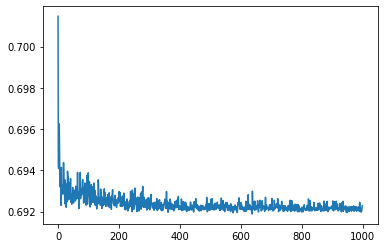

In [206]:
plt.plot(losses3)

In [194]:
plt.plot(losses3)

array([2, 5, 7, ..., 7, 5, 6])

In [182]:
testPredict[:30]

array([4, 9, 9, 3, 3, 3, 3, 8, 8, 4, 6, 6, 6, 6, 3, 6, 6, 6, 2, 6, 3, 6,
       6, 1, 9, 9, 9, 9, 9, 9])

In [181]:
dataset[1000+look_back:1000+look_back+30].reshape(-1)

array([3, 8, 0, 9, 5, 2, 5, 7, 2, 0, 1, 0, 6, 5, 4, 8, 5, 8, 6, 3, 2, 7,
       8, 8, 6, 5, 9, 3, 6, 1])

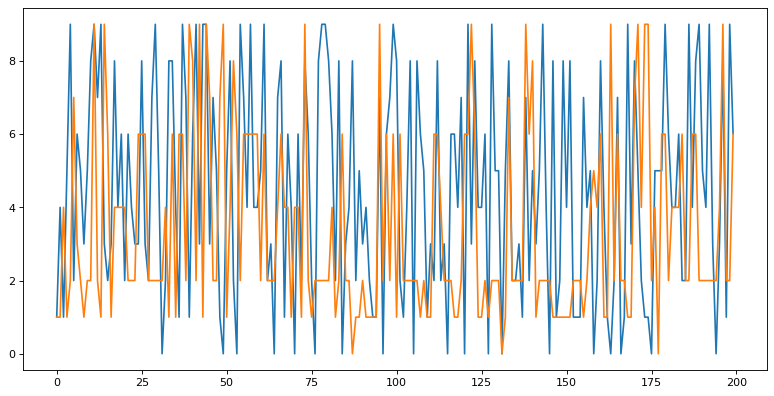

In [172]:
look_back=1
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dataset[look_back:200+look_back])
plt.plot(trainPredict2[:200])

In [127]:
dataset

array([[3],
       [1],
       [4],
       ...,
       [5],
       [6],
       [7]])

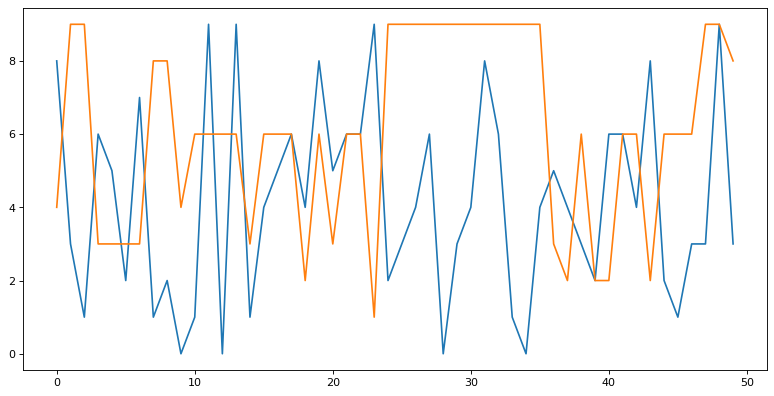

In [130]:
look_back=64
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t[:50],dataset[300-look_back:350-look_back])
plt.plot(testPredict[:50])

In [123]:
(testPredict[:10]  == dataset[300:310]).mean() 

0.08

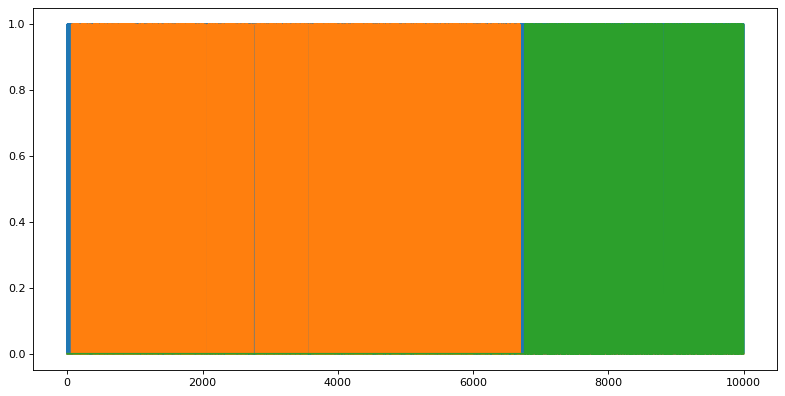

In [248]:
look_back=64
trainPredictPlot = np.empty_like(d.reshape(-1))
trainPredictPlot[:] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(d.reshape(-1))
testPredictPlot[:] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [187]:
dataset[1000:1300].reshape(-1)

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0])

In [226]:
r = np.random.binomial(1, 0.5,10000)

In [239]:
np.mean( r[6635:-1] == testPredict)

/home/mbastola/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


0.0

In [242]:
testPredict.shape[0] + trainPredict.shape[0]

9870

In [260]:
look_back = 64
np.mean(trainPredict == dataset[look_back:len(trainPredict)+look_back].reshape(-1))

0.5187641296156744

In [258]:
dataset[look_back:len(trainPredict)+look_back].reshape(-1)

array([1, 1, 1, ..., 0, 1, 0])

In [263]:
np.mean( r[:len(trainPredict)] == trainPredict)

0.48907309721175585